## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Окутин Денис Алексеевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 16 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

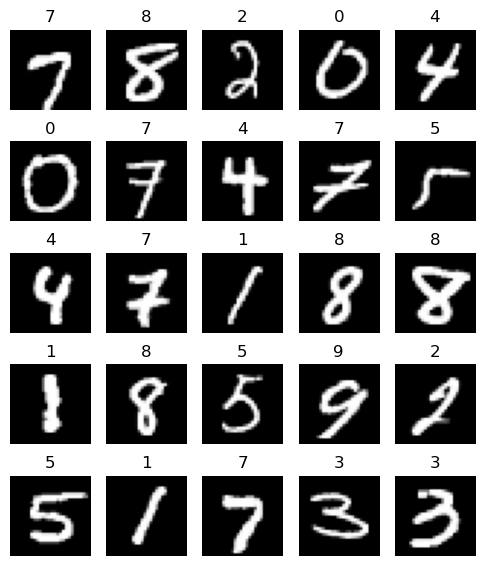

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [7]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [8]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

In [9]:
def show_loss(network):
    n_objects = 100
    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
    loss = loss_fn(activations, y)
    loss.backward()
show_loss(network)

forward 0.9783411622047424
forward 16.03217124938965
backward 0.034960292279720306
backward 0.1954704225063324


C:\Users\denok\anaconda3\envs\hw1\lib\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

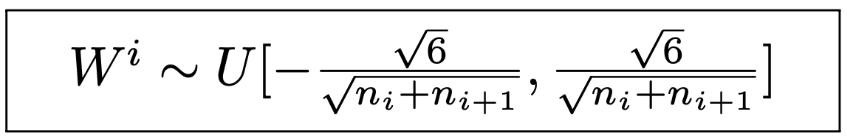

### He с семинара

In [10]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1,0,2/(28*28))
init_layer(layer_2,0,2/500)

In [11]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

In [12]:
show_loss(network)

forward 0.9783411622047424
forward 0.04311273992061615
backward 0.034960292279720306
backward 0.0008404547697864473


In [13]:
def xavier_init_layer(layer, a_range):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(-a_range, a_range)

def xavier(size_input, size_output):
    gain = nn.init.calculate_gain('tanh')
    d = (6 / (size_input + size_output))
    return np.sqrt(d)*gain

In [14]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

xavier_init_layer(layer_1,xavier(28*28,500))
xavier_init_layer(layer_2,xavier(500,10))

In [15]:
network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)
show_loss(network)

forward 0.9783411622047424
forward 0.7696714401245117
backward 0.034960292279720306
backward 0.016329411417245865


Видно, что инициализация HE обеспечивает гораздо более низкий лосс. Однако, поигравшись с функциями активации был сделан следующий вывод: для функции активации Tanh лучше использовать инициализацию Xavier(во избежание стремительных взрывов и затуханий градиентов), для функции активации ReLU лучше использовать инициализацию весов He.

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

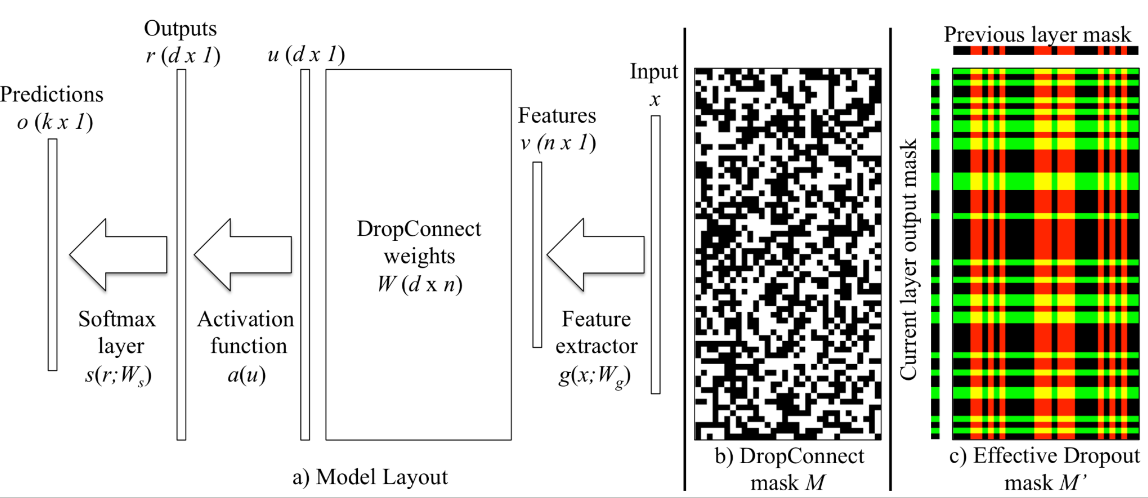

In [16]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = Variable(torch.zeros_like(self.linear.weight,requires_grad=False) + self.p)
        if self.training:
            mask = mask.bernoulli_(self.p)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [17]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [18]:
layers = [
    nn.Linear(196,256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,10)
]

Обучим получившуюся сеть:

In [19]:
from tqdm import tqdm
from IPython.display import clear_output
def train(net, optimizer, train_loader, test_loader,
                             epochs, criterion,
                             plot=True, verbose=True,
                            ):
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []

    try:
        for epoch in tqdm(range(epochs)):
            losses = []
            num_of_correct_pred = 0
            for batch_idx, (data, target) in enumerate(train_loader):
                optimizer.zero_grad()
                net_out = net(data)
                loss = criterion(net_out, target)
                losses.append(loss.data.item())

                pred = net_out.data.max(1)[1]
                num_of_correct_pred += pred.eq(target.data).sum().item()
                loss.backward()

                optimizer.step()

            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(num_of_correct_pred / len(train_loader.dataset))

            losses = []
            num_of_correct_pred = 0
            for data, target in test_loader:
                net_out = net(data)

                loss = criterion(net_out, target)
                losses.append(loss.data.item())

                pred = net_out.data.max(1)[1]
                num_of_correct_pred += pred.eq(target.data).sum().item()

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(num_of_correct_pred / len(test_loader.dataset))

            clear_output(wait=True)

            if verbose: # детализация выводимой информации
                print(
                      f'Network: <{type(net).__name__}>\n'
                      f'Optimizer: <{type(optimizer).__name__}>\n'
                      f'Loss type: <{type(criterion).__name__}>\n\n'
                      f'Epoch: {epoch+1}\n'
                      f'<Train/Test>\n'
                      f'Loss: {np.round(train_loss_epochs[-1], 3)}/{np.round(test_loss_epochs[-1], 3)} '
                      f'| Accuracy: {np.round(train_accuracy_epochs[-1], 3)}/{np.round(test_accuracy_epochs[-1], 3)}'
                     )

            if plot:
                plt.figure(figsize=(12, 5))

                # Отображение изменения ошибки
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')

                # Отображение изменения accuracy
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train')
                plt.plot(test_accuracy_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt as KI:
        print(KI)


Network: <TestNetwork>
Optimizer: <Adam>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.031/0.044 | Accuracy: 0.99/0.986


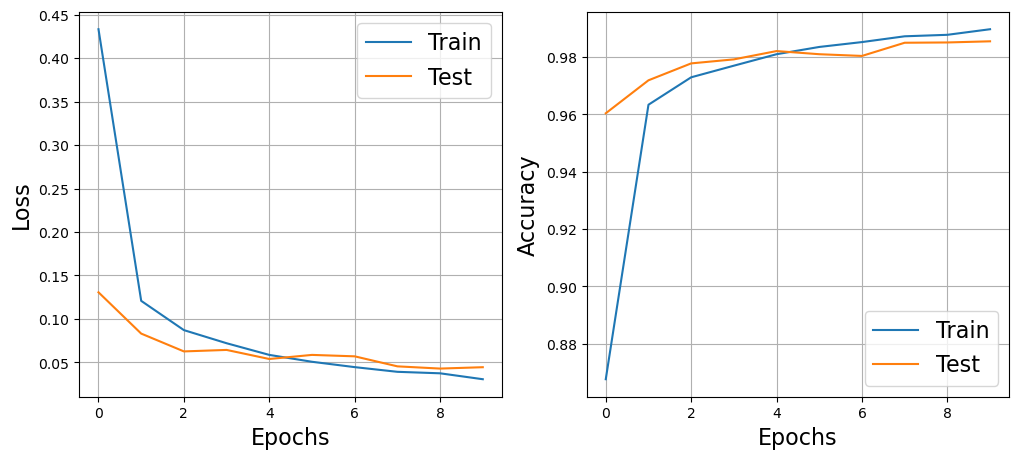

100%|██████████| 10/10 [04:30<00:00, 27.10s/it]


In [20]:
network = TestNetwork(nn.Sequential(*layers))
train(network,torch.optim.Adam(network.parameters(), lr=0.001), train_loader, test_loader, 10, nn.NLLLoss())


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями

In [21]:
layers = [
    nn.Linear(196,128),
    nn.Dropout(0.25),
    nn.ReLU(),
    nn.Linear(128,128),
    nn.Dropout(0.25),
    nn.ReLU(),
    nn.Linear(128,10)
]

Network: <TestNetwork>
Optimizer: <Adam>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.085/0.094 | Accuracy: 0.973/0.97


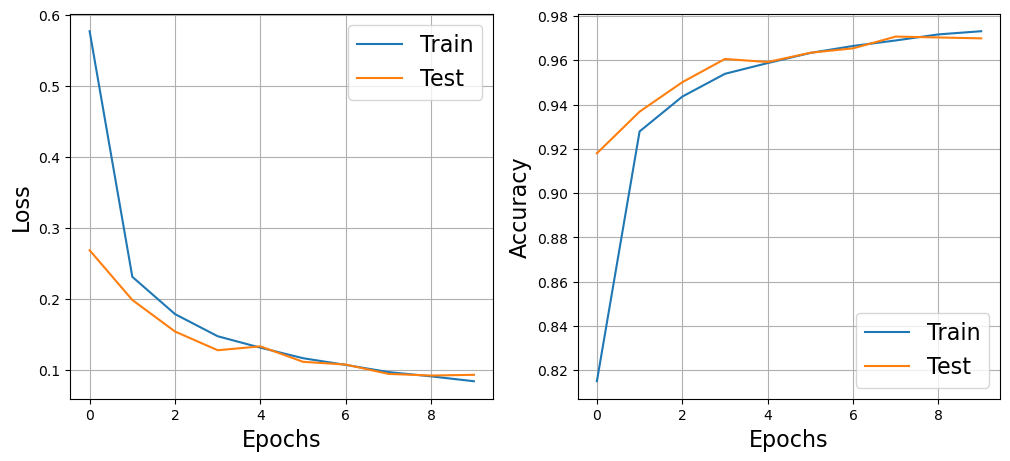

100%|██████████| 10/10 [03:21<00:00, 20.11s/it]


In [22]:
network = TestNetwork(nn.Sequential(*layers))
train(network,torch.optim.Adam(network.parameters(), lr=0.001), train_loader, test_loader, 10, nn.NLLLoss())

2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев

In [23]:
layers = [
    DropConnect(196,128),
    nn.ReLU(),
    DropConnect(128,128),
    nn.ReLU(),
    DropConnect(128,10),
    nn.ReLU()
]

Network: <TestNetwork>
Optimizer: <Adam>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.175/0.156 | Accuracy: 0.949/0.954


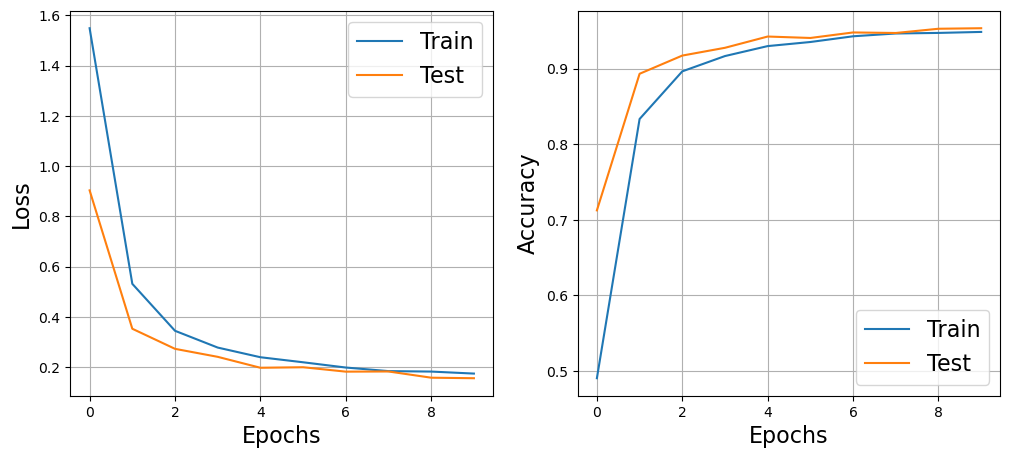

100%|██████████| 10/10 [03:18<00:00, 19.88s/it]


In [24]:
network = TestNetwork(nn.Sequential(*layers))
train(network,torch.optim.Adam(network.parameters(), lr=0.001), train_loader, test_loader, 10, nn.NLLLoss())

По графикам видно, что в целом Dropout + Linear выглядит чуть лучше, чем DropConnect. При этом видно, что на train качество модели немного хуже, чем на тесте при DropConnect, сеть обучается тяжелее


### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

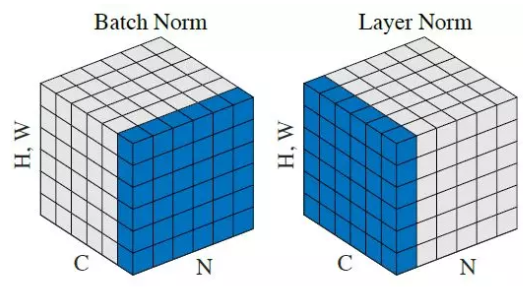

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [30]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))

    def forward(self, x):
        output = self.gamma*(x-x.mean())/torch.sqrt(x.std()+1e-8) + self.beta
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями

In [32]:
layers = [
    nn.Linear(196,128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128,128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128,10)
]

Network: <TestNetwork>
Optimizer: <Adam>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.021/0.057 | Accuracy: 0.993/0.983


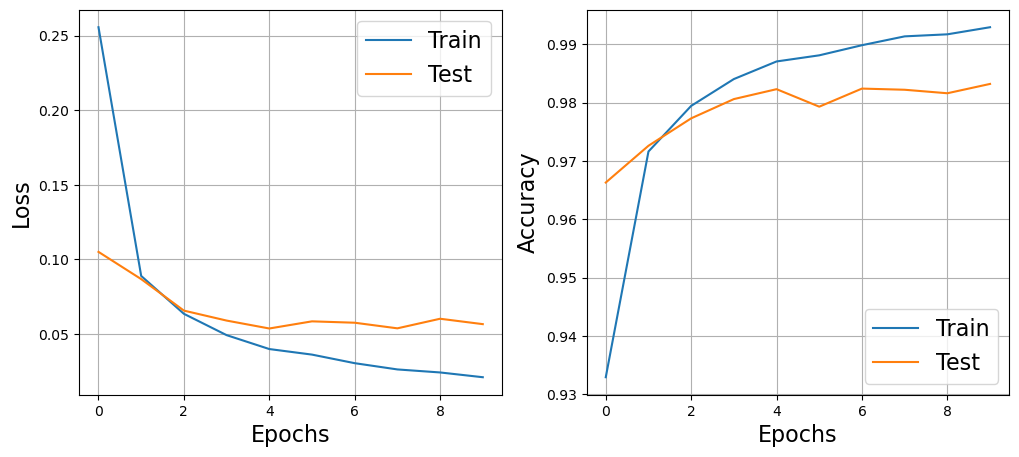

100%|██████████| 10/10 [03:17<00:00, 19.80s/it]


In [33]:
network = TestNetwork(nn.Sequential(*layers))
train(network,torch.optim.Adam(network.parameters(), lr=0.001), train_loader, test_loader, 10, nn.NLLLoss())

2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [34]:
layers = [
    nn.Linear(196,128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128,128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128,10)
]

Network: <TestNetwork>
Optimizer: <Adam>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.027/0.049 | Accuracy: 0.991/0.983


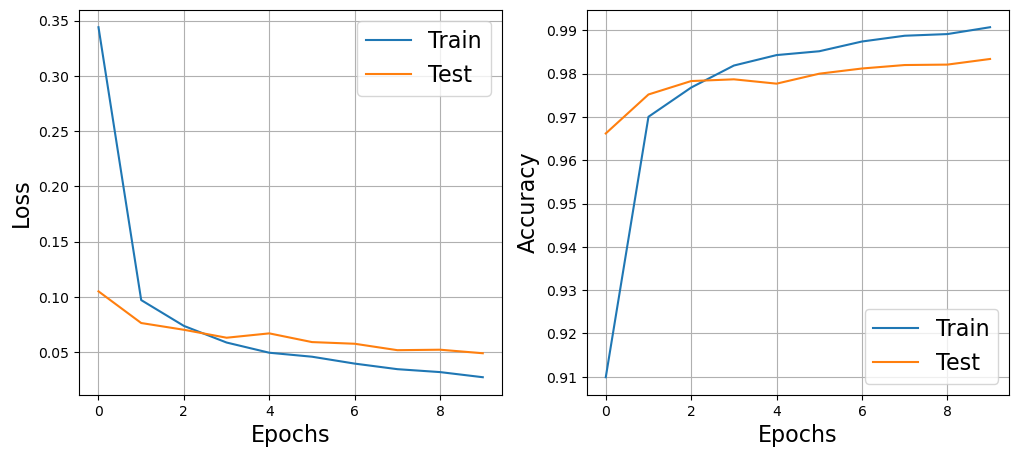

100%|██████████| 10/10 [03:13<00:00, 19.30s/it]


In [35]:
network = TestNetwork(nn.Sequential(*layers))
train(network,torch.optim.Adam(network.parameters(), lr=0.001), train_loader, test_loader, 10, nn.NLLLoss())

Видно, что в целом результаты схожи, но при Нормализации слоев сеть обучается на train лучше, чем при Нормализации батчей.